In [1]:
import tensorflow as tf
from tqdm import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pandas as pd
import string
from copy import deepcopy

In [14]:
data = pd.read_csv('clean_cpations_n_files.csv')
disney_captions = data.caption.to_list()
disney_images= data.folder.to_list()

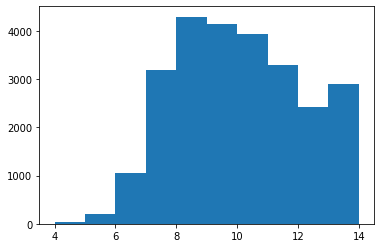

In [15]:
plt.hist([len(t.split(" ")) for t in disney_captions],bins=10);

In [7]:
img = tf.io.read_file(file_path)

In [65]:
def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img #, image_path

In [13]:
def load_image_aug(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 10)
        if bool(np.random.randint(2)):
            img = img +  tf.keras.backend.random_normal((299,299,3),0,np.random.randint(20))
        if bool(np.random.randint(2)):
            img = tf.image.random_contrast(img, 0, 2)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path

<start> how to floss properly during your office job <end>


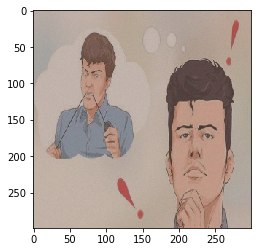

In [26]:
idx = np.random.randint(0,23000)
img = load_image_aug(disney_images[idx])
plt.imshow(img[0].numpy())
print(disney_captions[idx])

### SAVE FEATURE VECTORS

In [10]:
# # Get unique images
# encode_train = sorted(set(disney_images))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                                   (batch_features.shape[0], -1, batch_features.shape[3]))  # reshapa from  [32, 8, 8, 2048] to [32, 64, 2048]

    
#     for bf, p in zip(batch_features, path):
#         feature_name = p.numpy().decode("utf-8").split('/')[-1]
#         feature_path = './features/'+feature_name
#         np.save(feature_path, bf.numpy())

In [13]:
#plt.imshow(batch_features.numpy()[0,:,:,3])

### FIND VOCABULARY SIZE

In [27]:
words = [w.lower() for s in disney_captions for w in s.split(' ')]
print(f' vocab size: {len(set(words))}')
print(f' captions size: {len(disney_captions) }')
print(f' min len for captions {min(len(t.split(" ")) for t in disney_captions)}')
print(f' max len for captions {max(len(t.split(" ")) for t in disney_captions)}')

 vocab size: 14938
 captions size: 25488
 min len for captions 4
 max len for captions 14


In [29]:
from collections import Counter
all_words_count = Counter(words)
disney_words_count = Counter(disney_words)

In [30]:
disney_captions[-2]

'<start> remember dora the explorer this is her now <end>'

In [31]:
disney_images[-1]

'./disney_img/43557.jpg'

In [244]:
# disney_words_count.most_common()[:10]

In [245]:
# rare_words = []
# for word in all_words_count.most_common()[::-1]:
#     if word[1] < 2:
#         rare_words.append(word)
        
# print(f'Rare words: {len(rare_words)}')

In [246]:
# len(set(words)) - len(rare_words)

### 13000 WORDS VOCAB

In [28]:
top_k = 14500
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(disney_captions)

## DISNEY CAPTIONS 
train_seqs = tokenizer.texts_to_sequences(disney_captions)

In [29]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [30]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
max_sent_len = 16
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sent_len)
print(f'captions vector shape {cap_vector.shape}')

captions vector shape (25488, 16)


In [31]:
# Create training and validation sets using an 80-20 split

#image_features =   ['./features/'+name.split('/')[-1] for name in disney_images]


img_name_train, img_name_val, cap_train, cap_val = train_test_split(disney_images,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=42)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(22939, 22939, 2549, 2549)

In [32]:
img_name_train[:1]

['./disney_img/26550.jpg']

In [33]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 768 # should not be equal units
units = 512
vocab_size = top_k + 1
num_steps = len(disney_images) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

features_shape_two = 768
attention_features_two_shape = 17*17

In [34]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor = load_image(img_name)
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(map_func)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [35]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # embedding_size , 512 units 
        self.W2 = tf.keras.layers.Dense(units)  # target_len (max_len), 512 units
        self.V = tf.keras.layers.Dense(1)
        self.score = None
        self.attention_weights = None

    def call(self, features, hidden):
        # features = batch x 64 x 512
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        
        # hidden shape = batch_size x 16
        # hidden shape == (batch_size, hidden_size)
        
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        #self.f1 = self.W1(features)
        #self.f2 = self.W2(hidden_with_time_axis)
        self.score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        self.attention_weights = tf.nn.softmax(self.V(self.score), axis=1)
        

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = self.attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, self.attention_weights

#### DEFINE FEATURE EXTRACTOR ON Inception3

In [36]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer_mid = image_model.layers[164].output
hidden_layer_last = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, [hidden_layer_mid, hidden_layer_last])
image_features_extract_model.trainable = False

In [37]:
img = load_image_aug(disney_images[177])

f_one, f_two = image_features_extract_model(tf.expand_dims(img[0],0))

In [38]:
print(f_one.shape)
print(f_two.shape)

(1, 17, 17, 768)
(1, 8, 8, 2048)


In [40]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc_one = tf.keras.layers.Dense(embedding_dim)
        self.fc_two = tf.keras.layers.Dense(embedding_dim)

    def call(self, x_one, x_two):
        x_one = self.fc_one(x_one)
        x_one = tf.nn.relu(x_one)
        
        x_two = self.fc_two(x_two)
        x_two = tf.nn.relu(x_two)
        return x_one, x_two

In [41]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units, )
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention_one = BahdanauAttention(self.units)
        self.attention_two = BahdanauAttention(self.units)

    def call(self, x, features_one, features_two, hidden):
        # features = batch x 64 x 512
        # hidden shape = target.shape[0] == max_sent_len
        # defining attention as a separate model
        context_vector_one, attention_weights_one = self.attention_one(features_one, hidden)  
        context_vector_two, attention_weights_two = self.attention_two(features_two, hidden)  

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
#print('context_vector shape',context_vector.shape)
#print('X shape',x.shape)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector_one, 1),tf.expand_dims(context_vector_two, 1), x], axis=-1)
#print('X shape',x.shape)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
       
        return x, state, attention_weights_one

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
encoder= CNN_Encoder(embedding_dim)
#encoder_two = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [47]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [48]:
checkpoint_path = "./checkpoint_dis/augmented_test_8"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [49]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f'load from {ckpt_manager.latest_checkpoint}')
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [50]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_path, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        ### CNN Encoder
        batch_features_one, batch_features_two  = image_features_extract_model(img_path)
        # 768               2048
        
        # reshape ex. from  [32, 8, 8, 2048] to [32, 64, 2048]
        batch_features_one = tf.reshape(batch_features_one,
                                    (batch_features_one.shape[0], -1, batch_features_one.shape[3]))  
        
        batch_features_two = tf.reshape(batch_features_two,
                                    (batch_features_two.shape[0], -1, batch_features_two.shape[3]))
        
        features_one, features_two = encoder(batch_features_one, batch_features_two)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [153]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1676
Epoch 1 Batch 100 Loss 0.0603
Epoch 1 Batch 200 Loss 0.1190
Epoch 1 Batch 300 Loss 0.0854
Epoch 1 Loss 0.087279
Time taken for 1 epoch 98.51670813560486 sec

Epoch 2 Batch 0 Loss 0.1621
Epoch 2 Batch 100 Loss 0.0803
Epoch 2 Batch 200 Loss 0.0731
Epoch 2 Batch 300 Loss 0.0896
Epoch 2 Loss 0.085250
Time taken for 1 epoch 98.58168458938599 sec

Epoch 3 Batch 0 Loss 0.1370
Epoch 3 Batch 100 Loss 0.0953
Epoch 3 Batch 200 Loss 0.0716
Epoch 3 Batch 300 Loss 0.1104
Epoch 3 Loss 0.083000
Time taken for 1 epoch 98.92547106742859 sec

Epoch 4 Batch 0 Loss 0.1243
Epoch 4 Batch 100 Loss 0.1115
Epoch 4 Batch 200 Loss 0.1174
Epoch 4 Batch 300 Loss 0.1003
Epoch 4 Loss 0.080682
Time taken for 1 epoch 99.51197957992554 sec

Epoch 5 Batch 0 Loss 0.1517
Epoch 5 Batch 100 Loss 0.0782
Epoch 5 Batch 200 Loss 0.0980
Epoch 5 Batch 300 Loss 0.1222
Epoch 5 Loss 0.081079
Time taken for 1 epoch 98.7917902469635 sec

Epoch 6 Batch 0 Loss 0.1473
Epoch 6 Batch 100 Loss 0.1409
Epoch 6 Batch

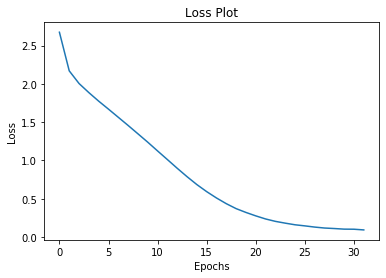

In [55]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### EVALUATE

In [107]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_two_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image), 0)
    img_tensor_val_one, img_tensor_val_two = image_features_extract_model(temp_input)
    print('img_tensor_val_one',img_tensor_val_one.shape)
    print('img_tensor_val_two',img_tensor_val_two.shape)
    img_tensor_val_one = tf.reshape(img_tensor_val_one, (img_tensor_val_one.shape[0], -1, img_tensor_val_one.shape[3]))
    img_tensor_val_two = tf.reshape(img_tensor_val_two, (img_tensor_val_two.shape[0], -1, img_tensor_val_two.shape[3]))
    features_one, features_two = encoder(img_tensor_val_one,img_tensor_val_two)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features_one, features_two, hidden)
        
        ### Slighlty randomize prediction - can be changed to Beam Search ###
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 10))

#     len_result = len(result)
#     for l in range(len_result):
#         temp_att = np.resize(attention_plot[l], (8, 8))
#         ax = fig.add_subplot(len_result//2, len_result//2, l+1)
#         ax.set_title(result[l])
#         img = ax.imshow(temp_image)
#         ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
#     plt.show()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(temp_image)

In [75]:
def evaluate_temp(image, t):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image), 0)
    img_tensor_val_one, img_tensor_val_two = image_features_extract_model(temp_input)
    img_tensor_val_one = tf.reshape(img_tensor_val_one, (img_tensor_val_one.shape[0], -1, img_tensor_val_one.shape[3]))
    img_tensor_val_two = tf.reshape(img_tensor_val_two, (img_tensor_val_two.shape[0], -1, img_tensor_val_two.shape[3]))
    features_one, features_two = encoder(img_tensor_val_one,img_tensor_val_two)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    score = 0

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)
        ### Slighlty randomize prediction - can be changed to Beam Search ###
        if i%1==0:
            #predictions = tf.nn.softmax(predictions/t)
            predicted_id = tf.random.categorical(predictions/t, 1)[0][0].numpy()
        else:
            predicted_id = np.argmax(predictions[0].numpy())
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, score/len(result)

        dec_input = tf.expand_dims([predicted_id], 0)
        score+=predictions[0][predicted_id].numpy()
    
    return result, score/len(result)

In [ ]:
### DEVIDE ON NUMBER OF WORDS

In [ ]:
#BM   https://github.com/yashk2810/Image-Captioning/blob/master/Image%20Captioning%20InceptionV3.ipynb
# https://github.com/njchoma/transformer_image_caption

In [879]:

# k = 3

# start_input = tokenizer.word_index['<start>']
# hidden = decoder.reset_state(batch_size=1)
# temp_input = tf.expand_dims(load_image(image)[0], 0)
# img_tensor_val = image_features_extract_model(temp_input)
# img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
# features = encoder(img_tensor_val)


# init = {'hidden':hidden,
#         'score':0,
#         'sentence':[start_input]}

# graphs = [deepcopy(init),deepcopy(init),deepcopy(init)]

# #dec_input = tf.expand_dims([0], 0)

# final = []

# for j in range(max_length):
#     for i, graph in enumerate(graphs):
#         #print(i)
#         predicted_id = graph['sentence'][-1]
#         dec_input = tf.expand_dims([predicted_id],0)
#         if tokenizer.index_word[predicted_id] == '<end>':
#             print('END')
#             print(' '.join([tokenizer.index_word[w] for w in  graph['sentence']]))
#             continue

#         hidden = graph['hidden']
#         predictions, hidden, _ = decoder(dec_input, features, hidden)
#         predicted_id = np.argsort(predictions.numpy()[0])[::-1][i]
        
#         graph['hidden'] = hidden
#         graph['score'] += predictions[0][predicted_id].numpy()
#         graph['sentence'].append(predicted_id)
#         dec_input = tf.expand_dims([predicted_id], 0)
#         print(f" i: {i}, predicted_id {predicted_id}, graph['score']: {graph['score']}, ")
#         # Choose the best one
#     if j % 2==0:
#         print('FIND BEST')
#         best_series = graphs[0]  
#         best_score = 0
#         for graph in graphs:
#             if best_score < graph['score']:
#                 #print(f"updated score {best_score} -> {graph['score']}")
#                 best_score = graph['score']
#                 best_series = deepcopy(graph)

#         graphs = [deepcopy(best_series),deepcopy(best_series),deepcopy(best_series)]

In [59]:
img_name_path = [p.replace('features','disney_old/disney_img') for  p  in img_name_val]

img_tensor_val_one (1, 17, 17, 768)
img_tensor_val_two (1, 8, 8, 2048)
Real Caption: <start> becoming a hitman step 1 earn your degree online <end>
0.7, how to fail at others <end>, score 22.440487384796143
0.9, how to become a pedophile <end>, score 21.1630376180013
1, how to become a college student in the usa <end>, score 23.207646656036378
1.2, how to become a slav <end>, score 20.323389689127605
Prediction Caption: how to be racist with your <unk> <end>


<Figure size 1440x720 with 0 Axes>

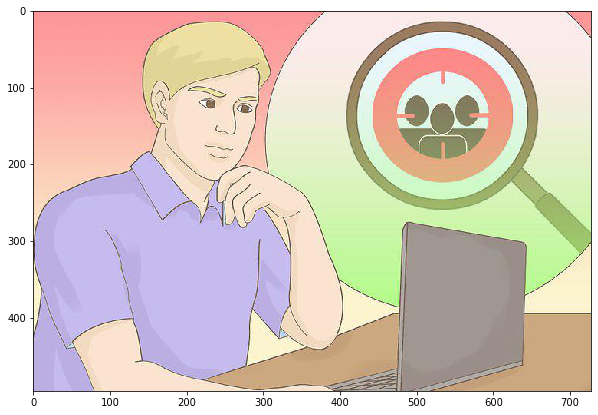

In [152]:
#### captions on the validation set

#img_name_val, cap_val
max_length = 27
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
results, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)

for t in [0.7,0.9,1,1.2]:
    res, a = evaluate_temp(image, t)
    print(f"{t}, {' '.join(res)}, score {a}")
print ('Prediction Caption:', ' '.join(results))
plot_attention(image, results, attention_plot)